In [1]:
import os, datetime
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import geopandas as gpd

In [2]:
import matplotlib.pyplot as plt
import contextily

In [3]:
from src import *

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
# delete bad perm krai outlier
filt = np.ones(4830)
filt[2932] = 0
filt = filt.astype(bool)

In [144]:
data = read_data('data/train_dataset_train_2.csv')[filt]
data_test = read_data('data/test_dataset_test_2.csv')
data_ts, data_id = process_data(data)
data_id['alt'] = pd.read_csv('data/altitude_train.csv')['alt'].tolist()
data_ts_test, data_id_test = process_data(data_test)
data_id_test['alt'] = pd.read_csv('data/altitude_test.csv')['alt'].tolist()

# Plots

In [159]:
# grid from:
# http://book.ecosens.org/modis-sinusoidal-grid-download/
# crs from:
# https://spatialreference.org/ref/sr-org/modis-sinusoidal-3/ogcwkt/

In [160]:
modis_grid = gpd.read_file('data/grid/modis_sinusoidal_grid_world.shp')
with open('data/grid/modis_sinusoidal_grid_world.prj') as f:
    modis_crs = f.read()

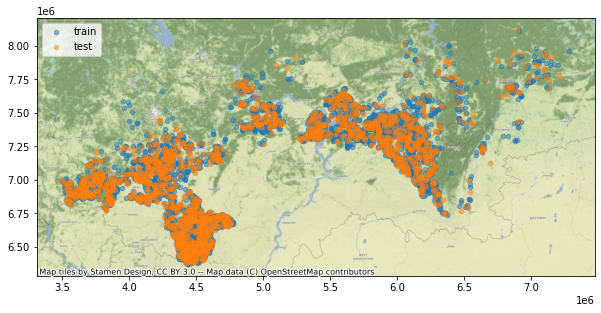

In [161]:
fig = plt.figure(figsize=(10,10))
base = data.to_crs(epsg=3857).geometry.centroid.plot(ax=plt.gca(), alpha=0.5, linewidth=1, markersize=20)
data_test.to_crs(3857).geometry.centroid.plot(ax=base, alpha=0.5, linewidth=1, markersize=20)
plt.legend(('train', 'test'))
contextily.add_basemap(base)

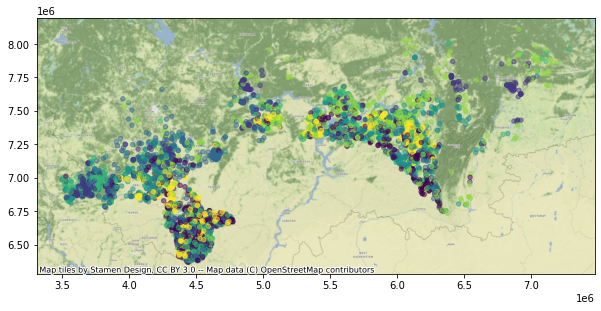

In [162]:
fig = plt.figure(figsize=(10,10))
base = data.to_crs(epsg=3857).geometry.centroid.plot(ax=plt.gca(), alpha=0.5, linewidth=1, markersize=20, c=data['crop'])
contextily.add_basemap(base)

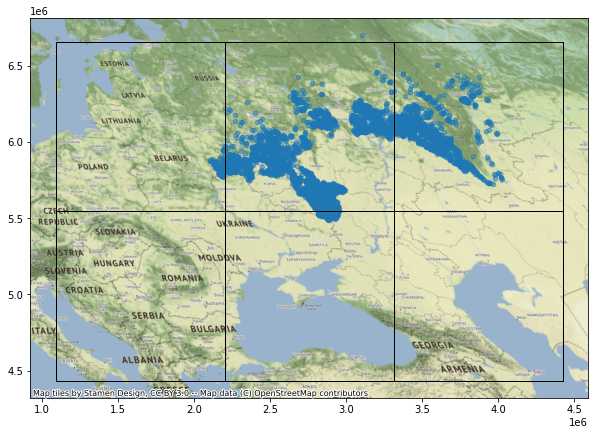

In [28]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
data.geometry.to_crs(modis_crs).centroid.plot(ax=ax, alpha=0.5, linewidth=1, markersize=20)
modis_grid[modis_grid['v'].isin([3,4]) & modis_grid['h'].isin([19,20,21])] \
    .to_crs(modis_crs).plot(ax=ax, edgecolor='black', facecolor='none')
contextily.add_basemap(ax, crs=modis_crs)

In [163]:
data_ts, data_id = process_data(data)
data_ts_test, data_id_test = process_data(data_test)

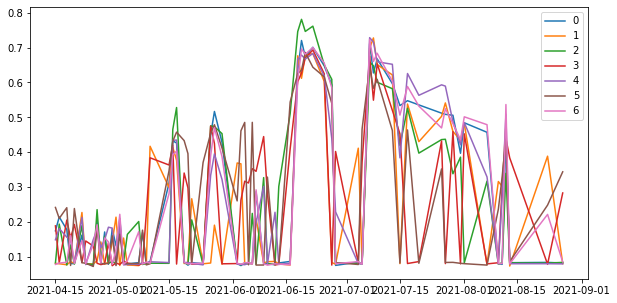

In [164]:
plt.figure(figsize=(10,5))
plot_data = data_ts.groupby(data_id['crop']).mean().T
plt.plot(plot_data);
plt.legend(plot_data.columns)

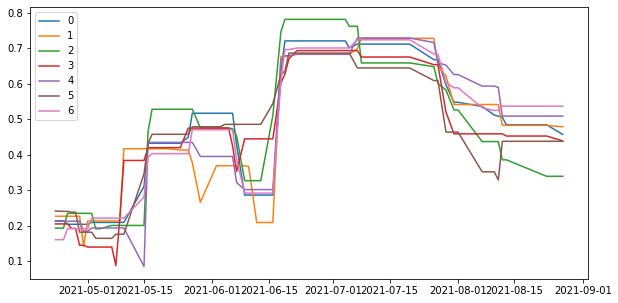

In [165]:
plt.figure(figsize=(10,5))
plot_data = data_ts.groupby(data_id['crop']).mean().T.rolling(7).max()
plt.plot(plot_data);
plt.legend(plot_data.columns)

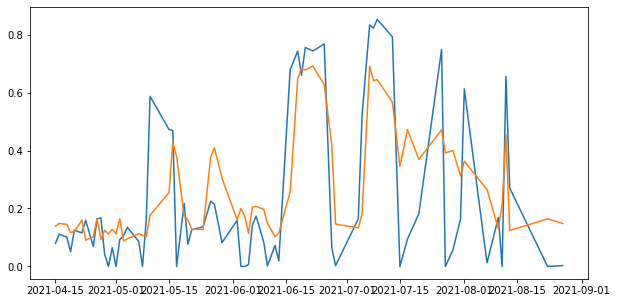

In [32]:
plt.figure(figsize=(10,5))
plt.plot(data_ts_test.iloc[5,:])
plt.plot(data_ts_test.mean())

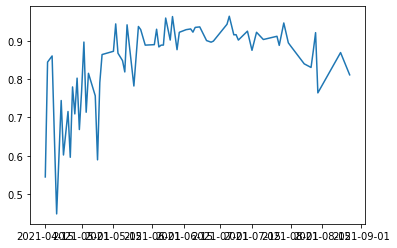

In [33]:
plt.plot(data_ts_test.max())

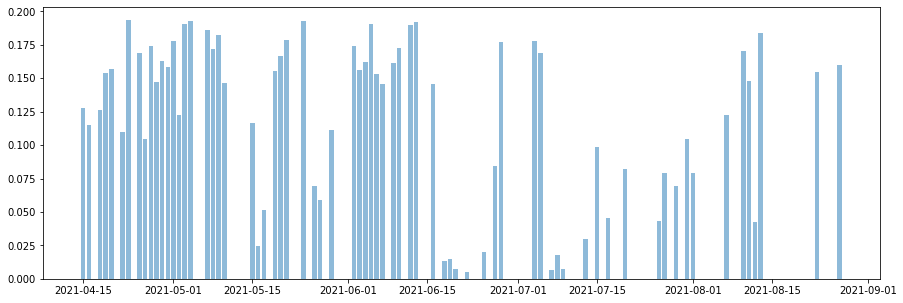

In [36]:
plt.figure(figsize=(15,5))
plt.bar(x=data_ts.columns, height=data_ts.eq(0.0).mean(), alpha=0.5);

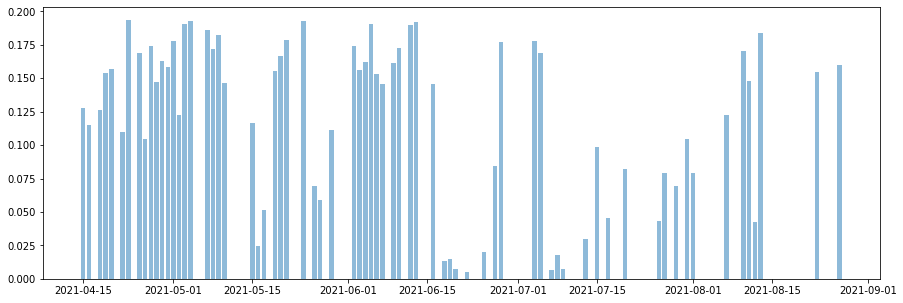

In [35]:
plt.figure(figsize=(15,5))
plt.bar(x=data_ts_test.columns, height=data_ts.eq(0.0).mean(), alpha=0.5);

# Sklearn Models

In [139]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score

In [155]:
data_ts_train, data_ts_val, data_id_train, data_id_val = train_test_split(data_ts, data_id, test_size=0.2, random_state=1)

In [156]:
data_train = data_ts_train
data_val = data_ts_val

In [157]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=1)
rf.fit(data_train, data_id_train['crop'])

RandomForestClassifier(random_state=1)

In [158]:
preds = rf.predict(data_val)
print(recall_score(preds, data_id_val['crop'], average='macro'))

0.9353023383211081


In [13]:
from sklearn.ensemble import GradientBoostingClassifier
cb = GradientBoostingClassifier(n_estimators=500, random_state=1)
cb.fit(data_train, data_id_train['crop'])

GradientBoostingClassifier(n_estimators=500, random_state=1)

In [14]:
preds = cb.predict(data_val)
print(recall_score(preds, data_id_val['crop'], average='macro'))

0.9519818869148222


# TSNE

In [321]:
from sklearn.manifold import TSNE
import seaborn as sns

In [322]:
alg = TSNE(random_state=5)
tsne = alg.fit_transform(data_ts.values)

<AxesSubplot:>

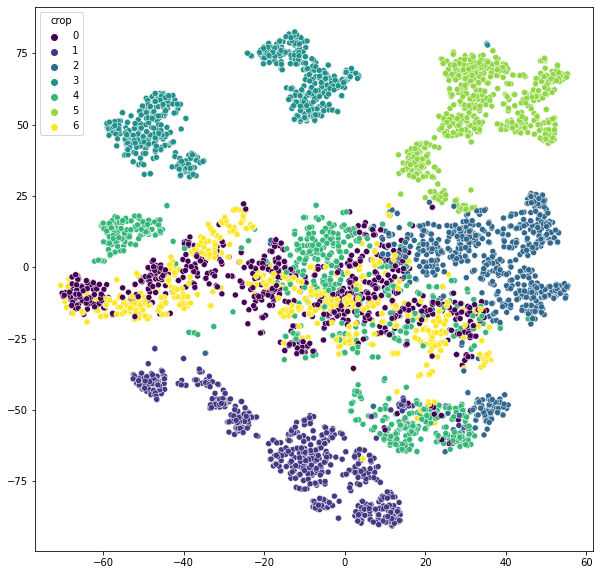

In [323]:
plt.figure(figsize=(10,10))
sns.scatterplot(*tsne.T, hue=data_id['crop'], palette='viridis')

## Test

In [275]:
test_hidden = pd.read_csv('test_hidden.csv')
test_hidden_orig = pd.read_csv('test_hidden_orig.csv')
test_preds = pd.read_csv('test_preds.csv')
test_y = pd.read_csv('test_y.csv')

In [281]:
alg = TSNE(random_state=5)
tsne_hidden = alg.fit_transform(test_hidden.values)

<AxesSubplot:>

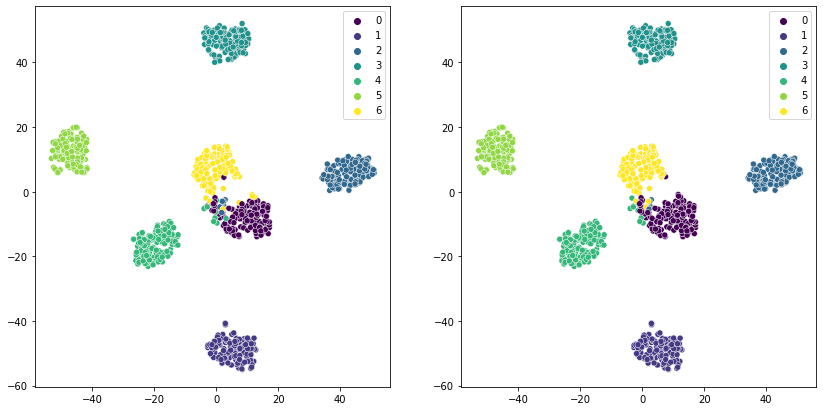

In [282]:
fig, ax = plt.subplots(1, 2, figsize=(14,7))
sns.scatterplot(*tsne_hidden.T, hue=test_y.values.squeeze(), palette='viridis', ax=ax[0])
sns.scatterplot(*tsne_hidden.T, hue=test_preds.values.argmax(1), palette='viridis', ax=ax[1])

In [246]:
test_idx = pd.read_csv('test_idx.csv')

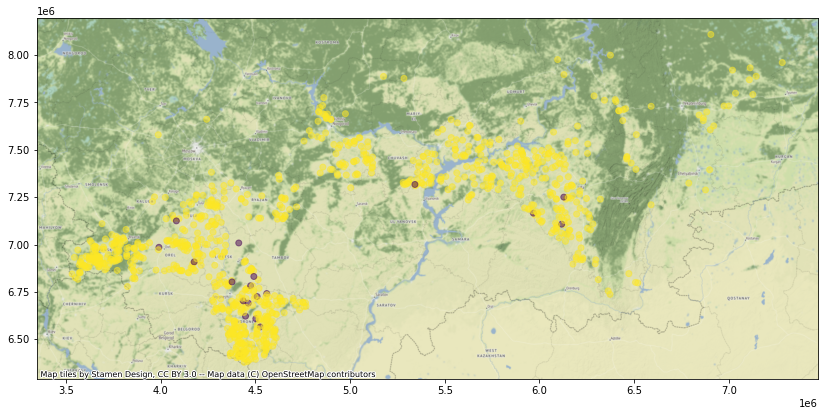

In [270]:
plt.figure(figsize=(14,7))
data_id.iloc[test_idx.values.squeeze(),:].to_crs(epsg=3857).centroid.plot(c=(test_preds.values.argmax(1)==test_y.values.squeeze()), ax=plt.gca(), alpha=0.5)
contextily.add_basemap(ax=plt.gca(), crs=3857)

In [276]:
alg2 = TSNE(random_state=5)
tsne_hidden_orig = alg2.fit_transform(test_hidden_orig.values)

<AxesSubplot:>

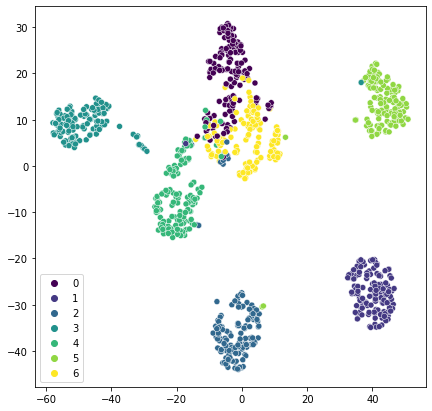

In [280]:
plt.figure(figsize=(7,7))
sns.scatterplot(*tsne_hidden_orig.T, hue=test_y.values.squeeze(), palette='viridis')